In [1]:

# Author: Thiago Akio Nakamura
# E-mail: akionakas@gmail.com

# Import necessary classes and libraries
%matplotlib inline
import numpy as np
import numpy.ma as ma
from StringIO import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap 
from scipy import linalg
from scipy.stats import randint
from operator import itemgetter

from time import time

from sklearn.mixture import MPPCA
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_blobs

In [2]:
# TODO deal with time 
# TODO deal with the names (elimated to generate a 2D array)
# The data should be on subdirectory called "data"
old_selected_data = np.genfromtxt("/Users/AkioNakamura/Dropbox/PFC/Codes/fdd/data/bomba10.csv",
              dtype=float,
              skip_header=3,
              autostrip=True,
              delimiter=",",)
print 'Loaded {} samples from {} variables.'.format(old_selected_data.shape[0], old_selected_data.shape[1])

Loaded 217441 samples from 43 variables.


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


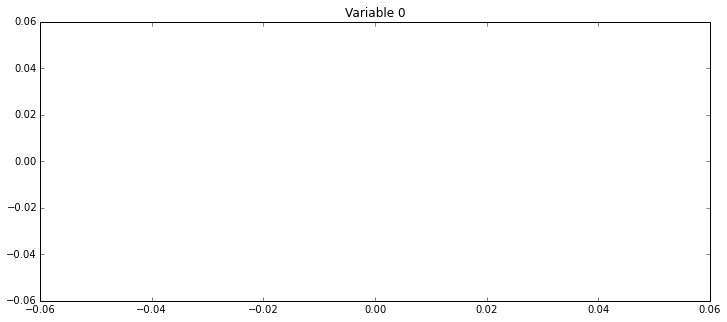

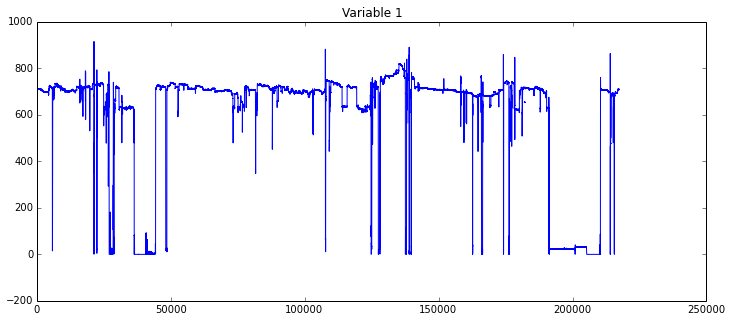

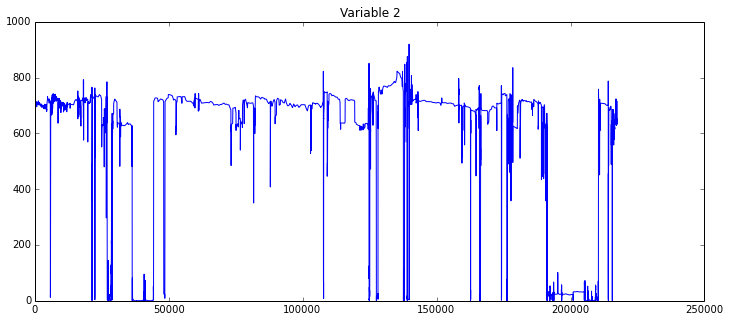

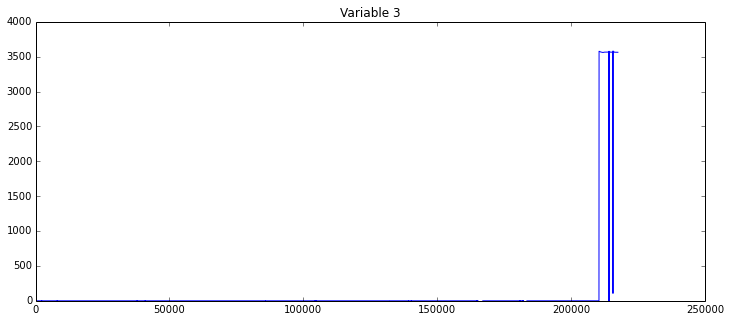

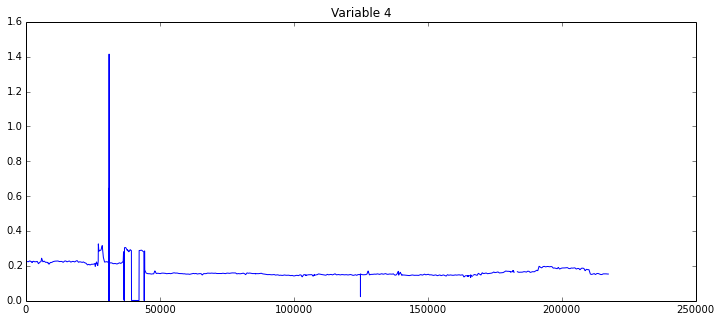

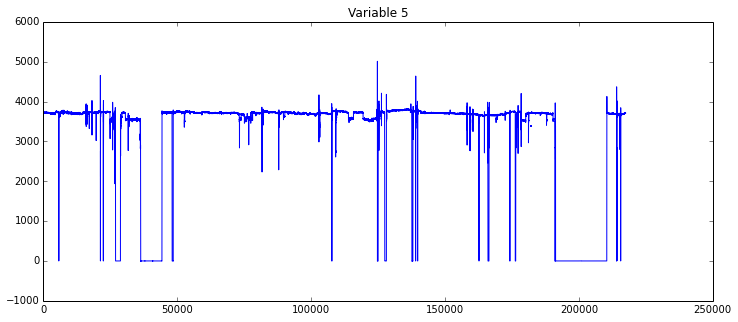

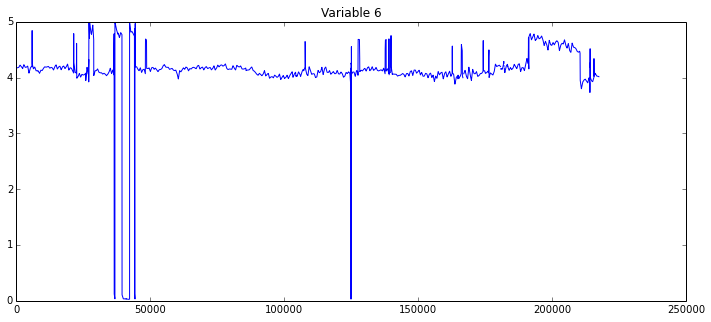

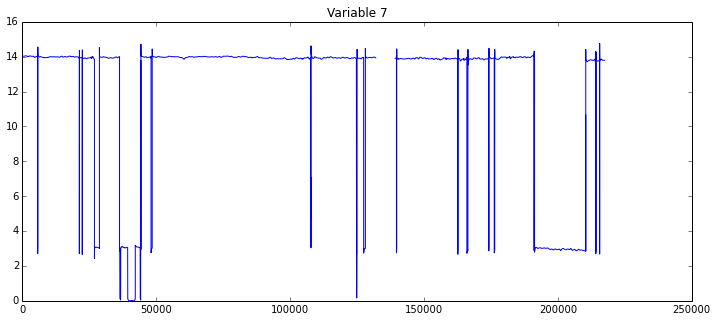

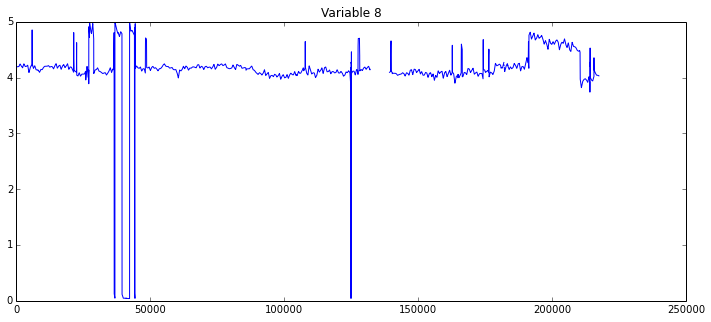

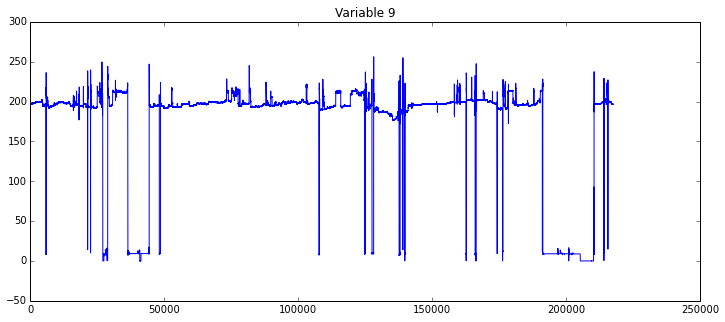

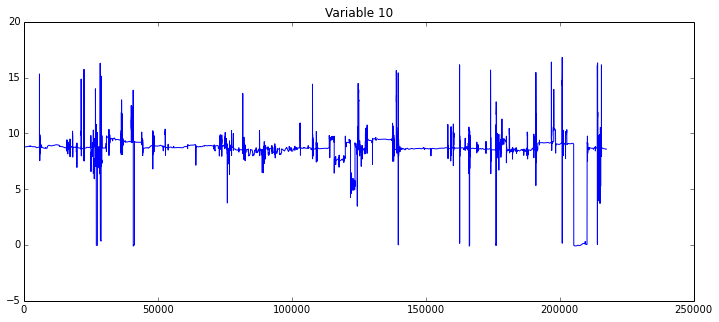

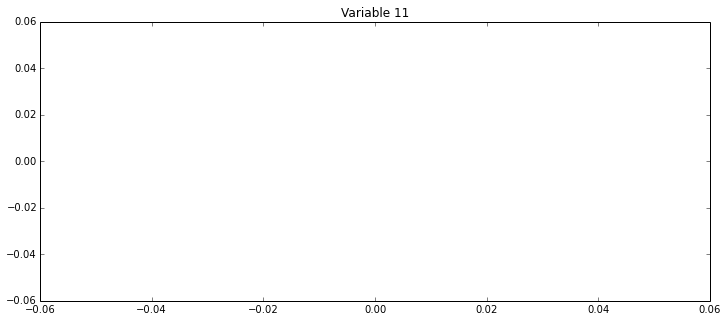

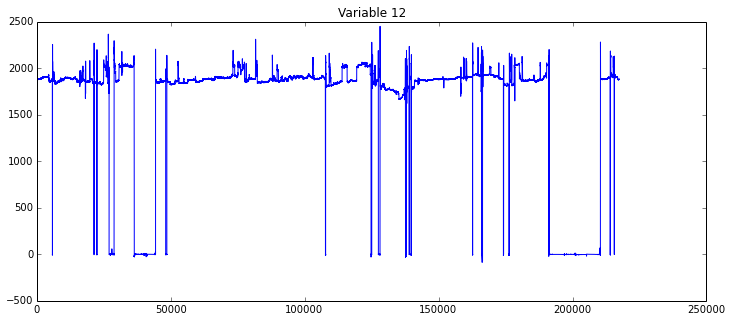

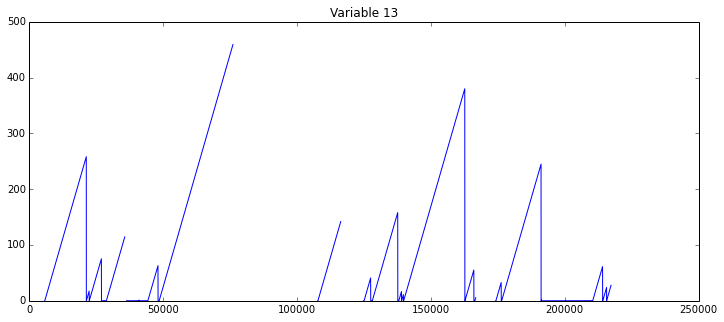

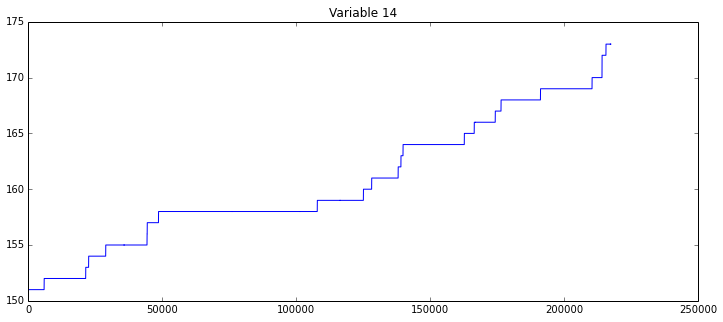

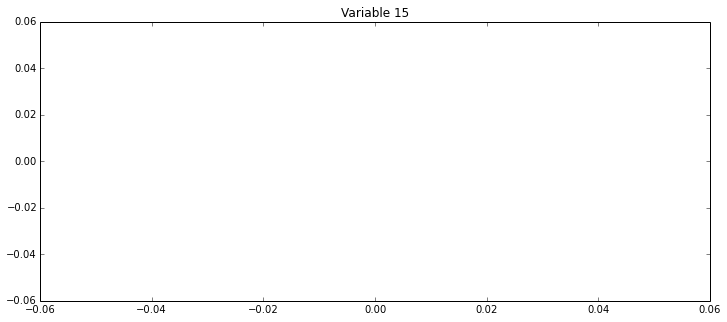

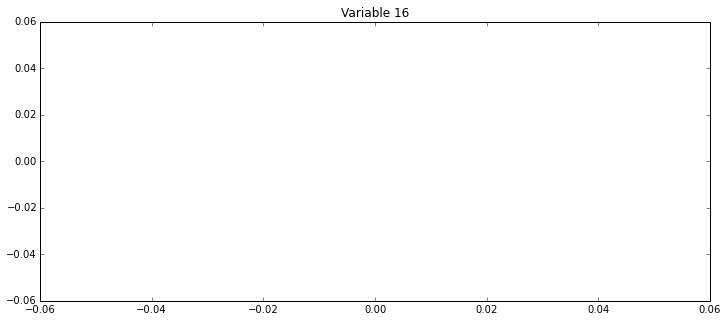

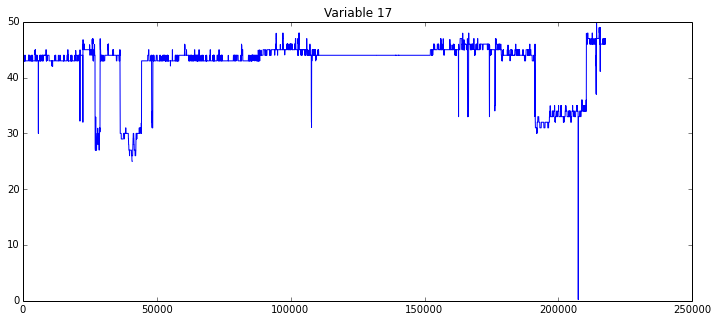

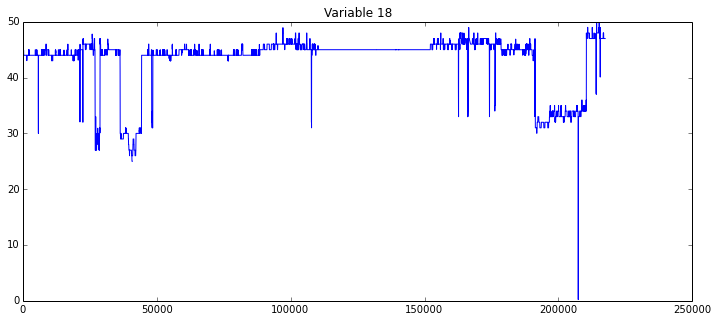

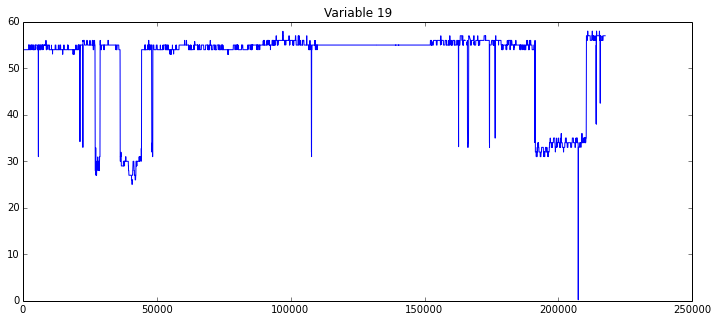

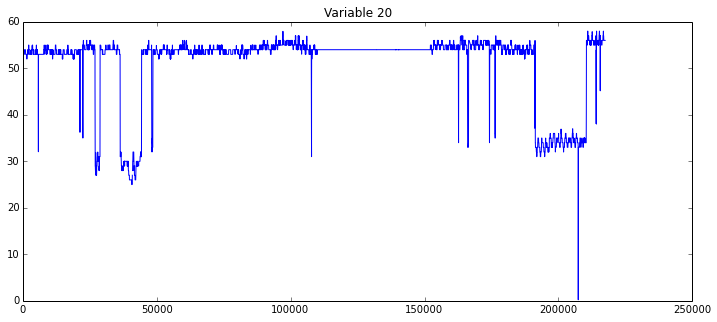

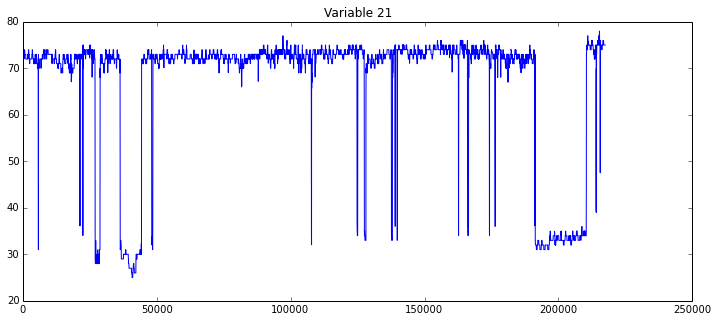

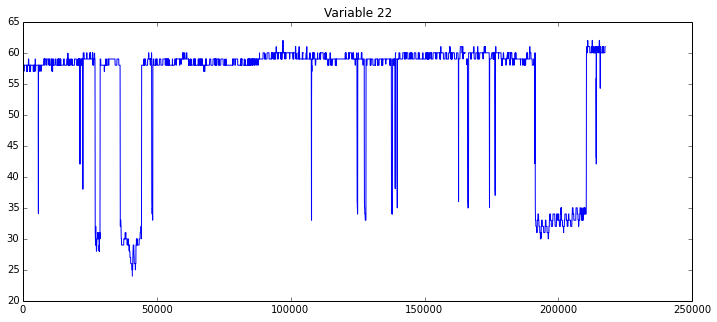

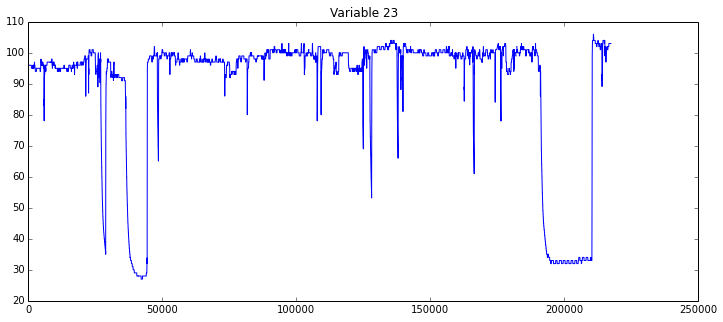

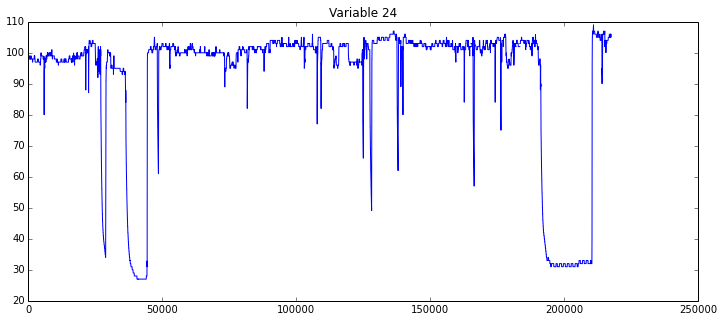

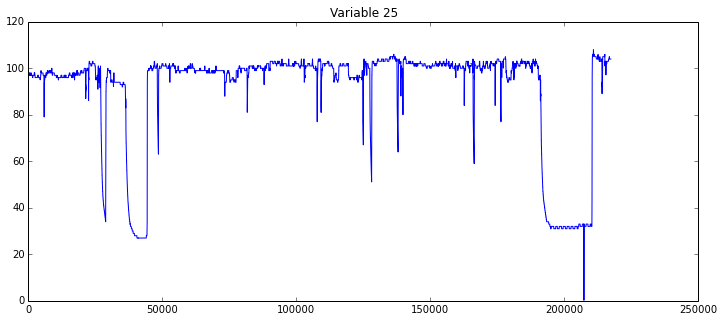

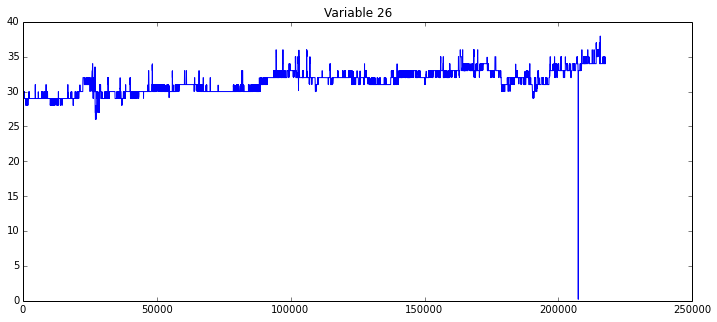

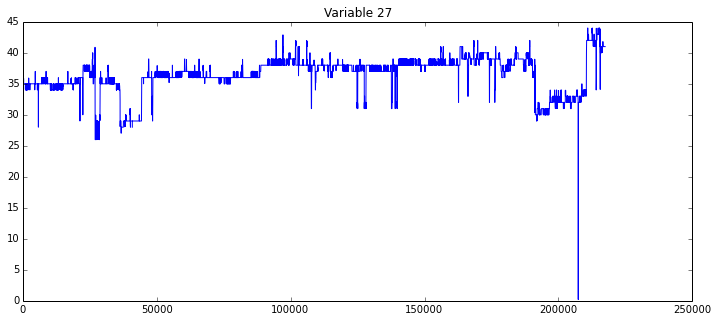

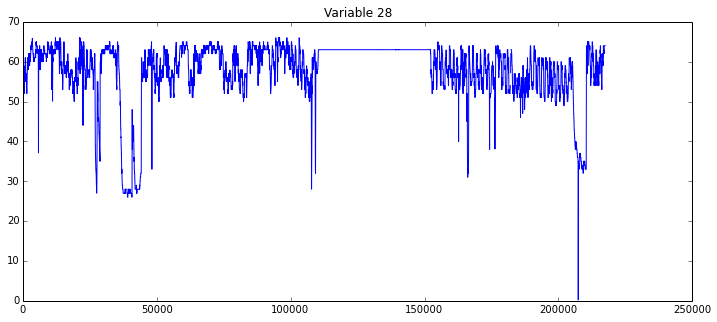

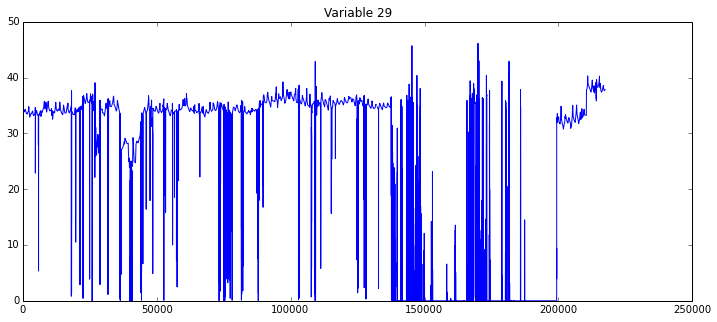

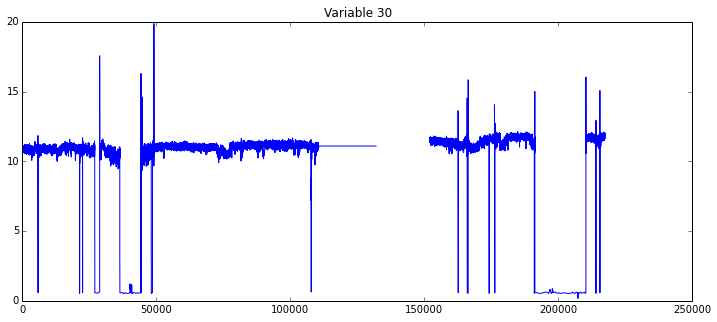

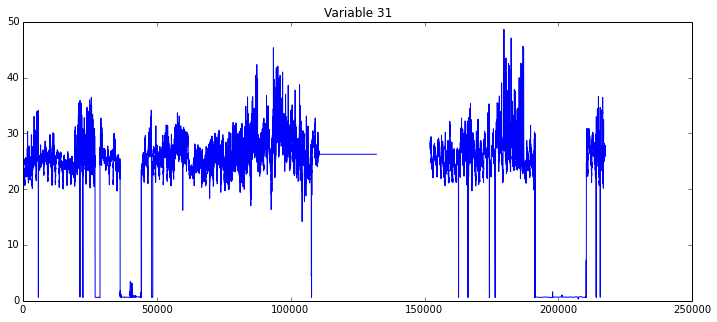

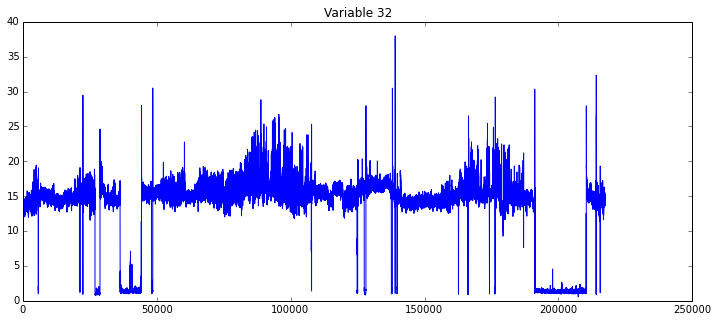

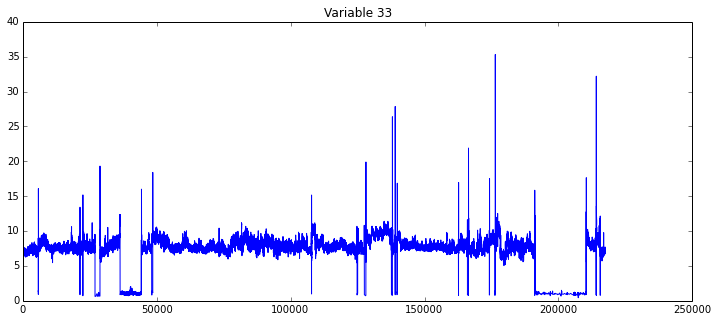

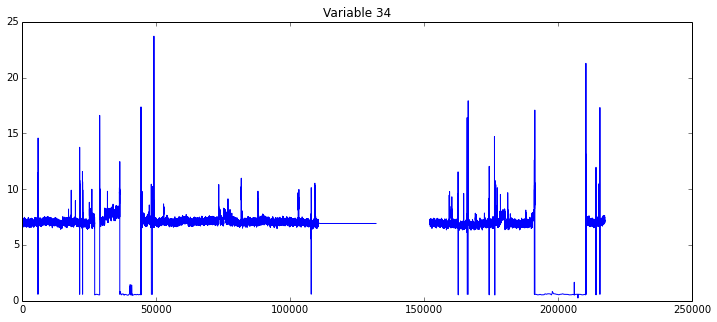

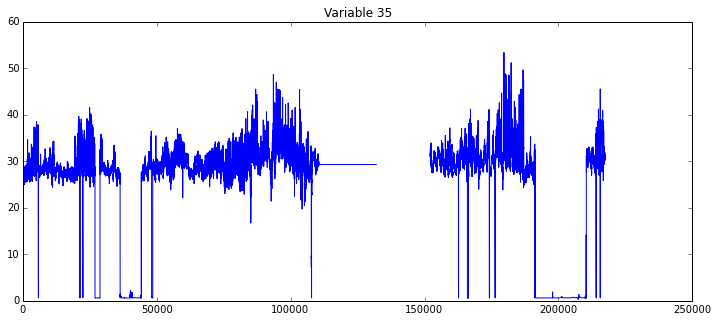

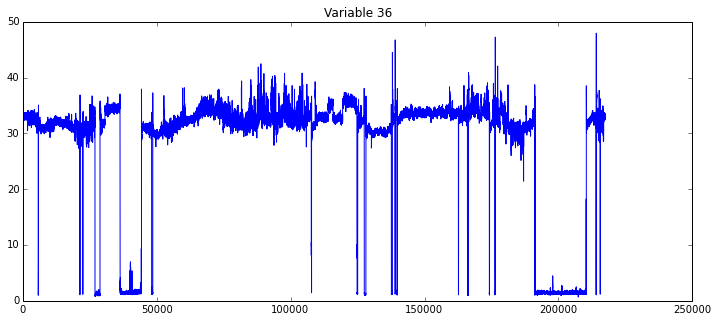

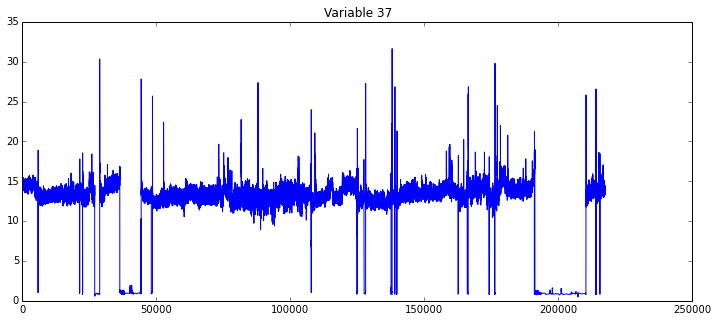

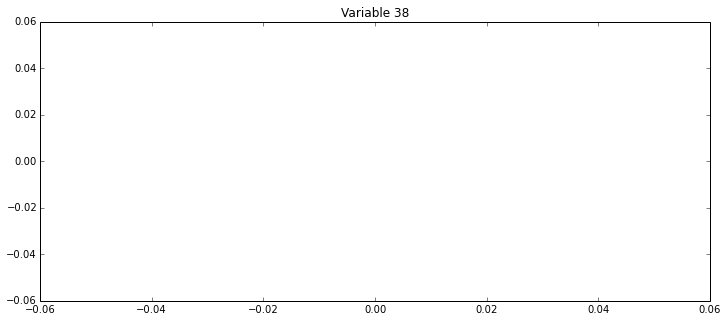

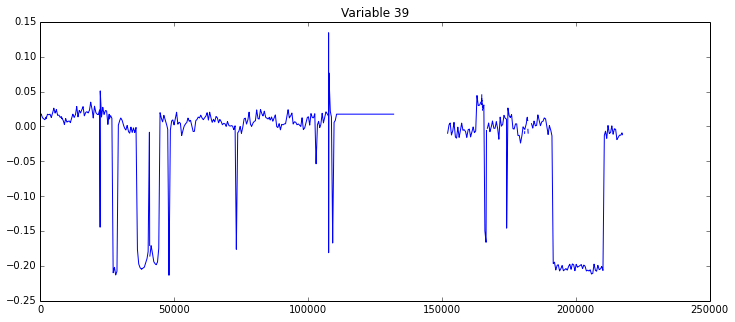

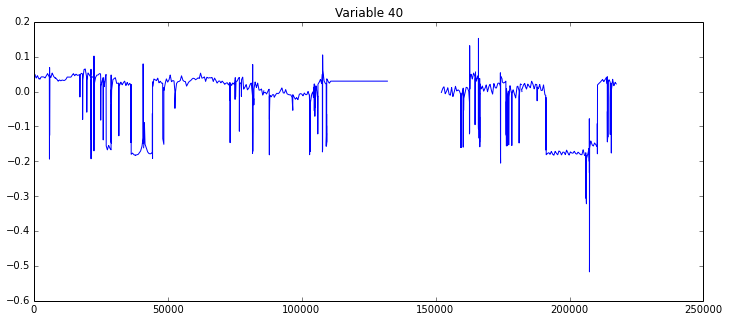

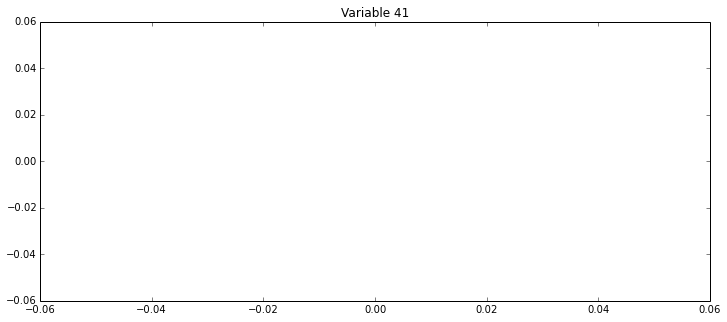

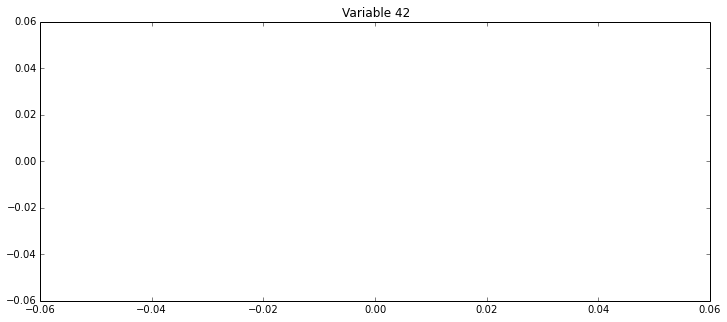

In [5]:
for i in np.arange(old_selected_data.shape[1]):
    plt.figure(figsize=(12, 5))
    plt.plot(old_selected_data[:, i])
    plt.title('Variable {}'.format(i))
    plt.show